# CCA Variants Comparison
A comparison of Kernel Canonical Correlation Analysis (KCCA) with three different types of kernel to Deep Canonical Correlation Analysis (DCCA). Each learns and computes kernels suitable for different situations. The point of this tutorial is to illustrate, in toy examples, the rough intuition as to when such methods work well and generate linearly correlated projections.

The simulated latent data has two signal dimensions draw from independent Gaussians. Two views of data were derived from this.

- View 1: The latent data.
- View 2: A transformation of the latent data. 

To each view, two additional independent Gaussian noise dimensions were added. 

Each 2x2 grid of subplots in the figure corresponds to a transformation and either the raw data or a CCA variant. The x-axes are the data from view 1 and the y-axes are the data from view 2. Plotted are the correlations between the signal dimensions of the raw views and the top two components of each view after a CCA variant transformation. Linearly correlated plots on the diagonals of the 2x2 grids indicate that the CCA method was able to successfully learn the underlying functional relationship between the two views.


In [2]:
from mvlearn.embed import KCCA, DCCA
from mvlearn.datasets import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns

In [3]:
## Make Latents
n = 200
mu = [[0,1], [0,-1]]
sigma = 2*np.array([np.eye(2), np.eye(2)])
pi = [0.5,0.5]
GM_train = GaussianMixture(mu,sigma,n,class_probs=pi)

## Test
GM_test = GaussianMixture(mu,sigma,n,class_probs=pi)

## Make 2 views
n_noise = 2
transforms = ['linear', 'poly', 'sin']

Xs_train = []
Xs_test = []
for transform in transforms:
    GM_train.sample_views(transform=transform, n_noise=n_noise)
    GM_test.sample_views(transform=transform, n_noise=n_noise)

    Xs_train.append(GM_train.get_Xy()[0])
    Xs_test.append(GM_test.get_Xy()[0])

In [4]:
## Plotting parameters
labels = GM_test.latent[:,0]
cmap = matplotlib.colors.ListedColormap(sns.diverging_palette(240, 10, n=len(labels), center='light').as_hex())
cmap = 'coolwarm'

method_labels = ['Raw Views', 'Linear KCCA', 'Polynomial KCCA', 'Gaussian KCCA', 'DCCA']
transform_labels = ['Linear Transform', 'Polynomial Transform', 'Sinusoidal Transform']

In [5]:
input_size1, input_size2 = Xs_train[0][0].shape[1], Xs_train[0][1].shape[1]
outdim_size = min(Xs_train[0][0].shape[1], 2)
layer_sizes1 = [256, 256, outdim_size]
layer_sizes2 = [256, 256, outdim_size]
methods = [KCCA(ktype='linear', reg = 0.1, degree=2.0, constant=0.1, n_components = 2),
           KCCA(ktype='poly', reg = 0.1, degree=2.0, constant=0.1, n_components = 2),
           KCCA(ktype='gaussian', reg = 1.0, sigma=2.0, n_components = 2),
           DCCA(input_size1, input_size2, outdim_size, layer_sizes1, layer_sizes2, epoch_num=400)
]

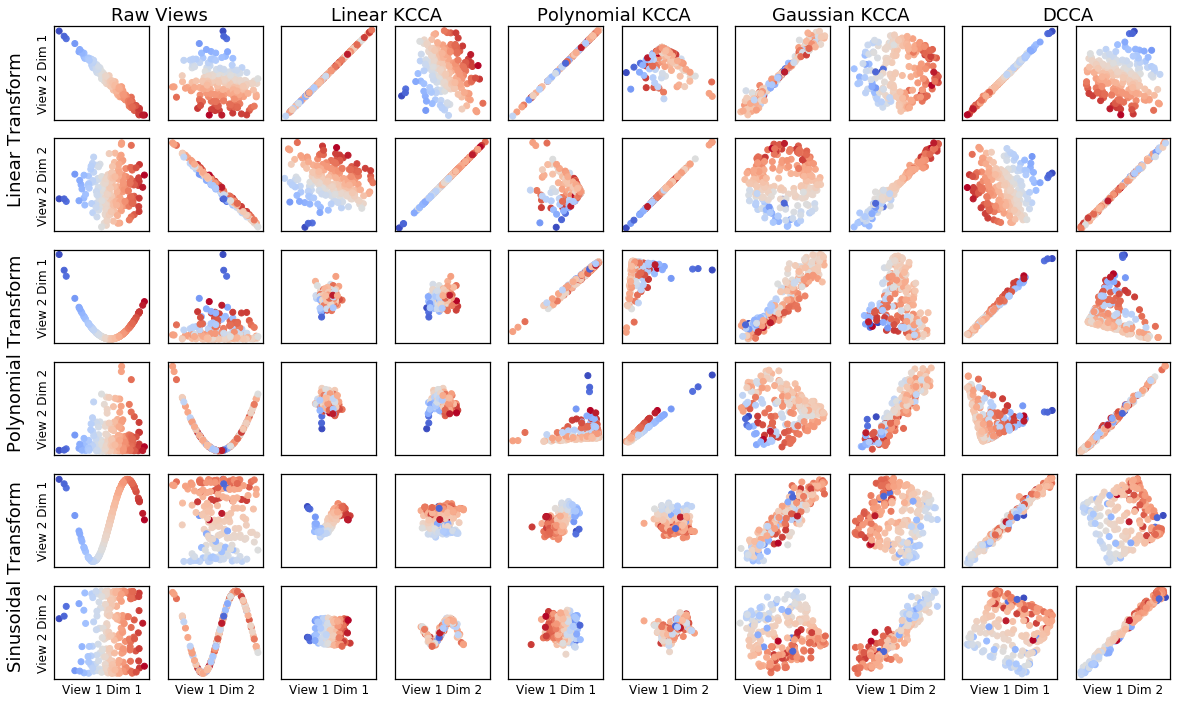

In [15]:
fig, axes = plt.subplots(3*2, 5*2, figsize=(20,12))
sns.set_context('notebook')

for r,transform in enumerate(transforms):
    axs = axes[2*r:2*r+2,:2]
    for i,ax in enumerate(axs.flatten()):
        dim2 = int(i / 2)
        dim1 = i % 2
        ax.scatter(
            Xs_test[r][0][:, dim1],
            Xs_test[r][1][:, dim2],
            cmap=cmap,
            c=labels,
        )
        ax.set_xticks([], [])
        ax.set_yticks([], [])
        if dim1 == 0:
            ax.set_ylabel(f"View 2 Dim {dim2+1}")
        if dim1 == 0 and dim2 == 0:
            ax.text(-0.5, -0.1, transform_labels[r], transform=ax.transAxes, fontsize=18, rotation=90, verticalalignment='center')
        if dim2 == 1 and r == len(transforms)-1:
            ax.set_xlabel(f"View 1 Dim {dim1+1}")
        if i == 0 and r == 0:
            ax.set_title(method_labels[r], {'position':(1.11,1), 'fontsize':18})
    
    for c,method in enumerate(methods):
        axs = axes[2*r:2*r+2,2*c+2:2*c+4]
        Xs = method.fit(Xs_train[r]).transform(Xs_test[r])
        for i,ax in enumerate(axs.flatten()):
            dim2 = int(i / 2)
            dim1 = i % 2
            ax.scatter(
                Xs[0][:, dim1],
                Xs[1][:, dim2],
                cmap=cmap,
                c=labels,
            )
            if dim2 == 1 and r == len(transforms)-1:
                ax.set_xlabel(f"View 1 Dim {dim1+1}")
            if i == 0 and r == 0:
                ax.set_title(method_labels[c+1], {'position':(1.11,1), 'fontsize':18})
            ax.axis("equal")
            ax.set_xticks([], [])
            ax.set_yticks([], [])